<a href="https://colab.research.google.com/github/MiraInfern/ML/blob/main/Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 3

1. Выбрать номинальное значение как целевую переменную
2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)
3. Выбрать `best_features`
4. Сделать нормализацию данных (scaler, onehotencoding)
4. Обучить модель логистической регрессии
5. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

In [2]:
import pandas as pd

In [3]:
EDUCATION_DATA_FILE = "/education_inequality_data.csv"
df = pd.read_csv(EDUCATION_DATA_FILE)

In [4]:
median_score = 71.5
df['is_score_high'] = (df['avg_test_score_percent'] > median_score).astype(int)
y_log = df['is_score_high']

print(f"Распределение новой целевой переменной:\n{y_log.value_counts()}")

Распределение новой целевой переменной:
is_score_high
0    518
1    482
Name: count, dtype: int64


### EDA

In [5]:
from scipy.stats import chi2_contingency

categorical_cols = ['state', 'school_type', 'grade_level']
print("Проверка зависимости между категориальными признаками (Chi-squared)")

for col_a in categorical_cols:
    for col_b in categorical_cols:
        if col_a != col_b:
            contingency_table = pd.crosstab(df[col_a], df[col_b])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)

            if p_value < 0.05:
                print(f"Зависимость между {col_a} и {col_b}: СИЛЬНАЯ (p={p_value:.4f})")
            else:
                print(f"Зависимость между {col_a} и {col_b}: СЛАБАЯ (p={p_value:.4f})")


print("Зависимость целевой  от категориальных признаков")
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], y_log)
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    if p_value < 0.05:
        print(f"Зависимость {col} от is_score_high: ЕСТЬ (p={p_value:.4f})")
    else:
        print(f"Зависимость {col} от is_score_high: НЕТ (p={p_value:.4f})")

Проверка зависимости между категориальными признаками (Chi-squared)
Зависимость между state и school_type: СЛАБАЯ (p=0.7372)
Зависимость между state и grade_level: СЛАБАЯ (p=0.6685)
Зависимость между school_type и state: СЛАБАЯ (p=0.7372)
Зависимость между school_type и grade_level: СЛАБАЯ (p=0.8459)
Зависимость между grade_level и state: СЛАБАЯ (p=0.6685)
Зависимость между grade_level и school_type: СЛАБАЯ (p=0.8459)
Зависимость целевой  от категориальных признаков
Зависимость state от is_score_high: НЕТ (p=0.4784)
Зависимость school_type от is_score_high: НЕТ (p=0.5348)
Зависимость grade_level от is_score_high: НЕТ (p=0.6203)


In [28]:
categorical_features = ['school_type', 'grade_level']


numeric_features = [
    'internet_access_percent',
    'dropout_rate_percent',
    'percent_low_income'

]

best_features = categorical_features + numeric_features
X_log_best = df[best_features].copy()

print("best_features: ", best_features)

best_features:  ['school_type', 'grade_level', 'internet_access_percent', 'dropout_rate_percent', 'percent_low_income']


### Нормализация и Кодирование

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
X_cat_encoded = encoder.fit_transform(X_log_best[categorial_features])
cat_feature_names = encoder.get_feature_names_out(categorial_features)
X_cat_df = pd.DataFrame(X_cat_encoded, columns=cat_feature_names, index=X_log_best.index)


scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_log_best[numeric_features])
X_num_df = pd.DataFrame(X_num_scaled, columns=numeric_features, index=X_log_best.index)


X_processed = pd.concat([X_num_df, X_cat_df], axis=1)

print(f"Размер обработанной матрицы признаков: {X_processed.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_log, test_size=0.3, random_state=42, stratify=y_log
)
print(f"Размер обучающей выборки: {X_train.shape[0]}, тестовой: {X_test.shape[0]}")

Размер обработанной матрицы признаков: (1000, 7)
Размер обучающей выборки: 700, тестовой: 300


### Model

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Предсказания

In [31]:
model_log = LogisticRegression(solver='liblinear', random_state=42)
model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)
y_proba = model_log.predict_proba(X_test)[:, 1]

### Вывод метрик качества

In [32]:
print("Метрики Логистической Регрессии")
print(f"Accuracy (Точность): {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (Прецизионность): {precision_score(y_test, y_pred):.4f}")
print(f"Recall (Полнота): {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

Метрики Логистической Регрессии
Accuracy (Точность): 0.4667
Precision (Прецизионность): 0.4227
Recall (Полнота): 0.2828
F1-Score: 0.3388
ROC AUC Score: 0.4323


Accuracy: Общая доля правильных предсказаний составляет 0.4667, что указывает на низкую эффективность модели в целом, близкую к случайному угадыванию.

Precision: Показатель ≈ 0.4227 означает, что из всех школ, предсказанных как "Высокий балл", только ≈ 42.27% действительно принадлежали к этому классу, демонстрируя высокий уровень ложноположительных ошибок.

Recall (Полнота): Значение ≈ 0.2828 является низким, что говорит о том, что модель смогла обнаружить только ≈ 28.28% школ, которые на самом деле имели "Высокий балл" (много пропущенных положительных случаев).

F1-Score: Усредненный показатель точности и полноты ≈ 0.3388 подтверждает слабый баланс между этими двумя метриками и общую низкую производительность классификатора.

ROC AUC Score: Значение ≈ 0.4323, близкое к 0.4, указывает на то, что модель практически не имеет дискриминационной способности к разделению классов "Score High" и "Score Low", работая как случайный классификатор.


/tmp/ipython-input-3420193498.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=significant_coefficients.values, y=significant_coefficients.index, palette=colors)


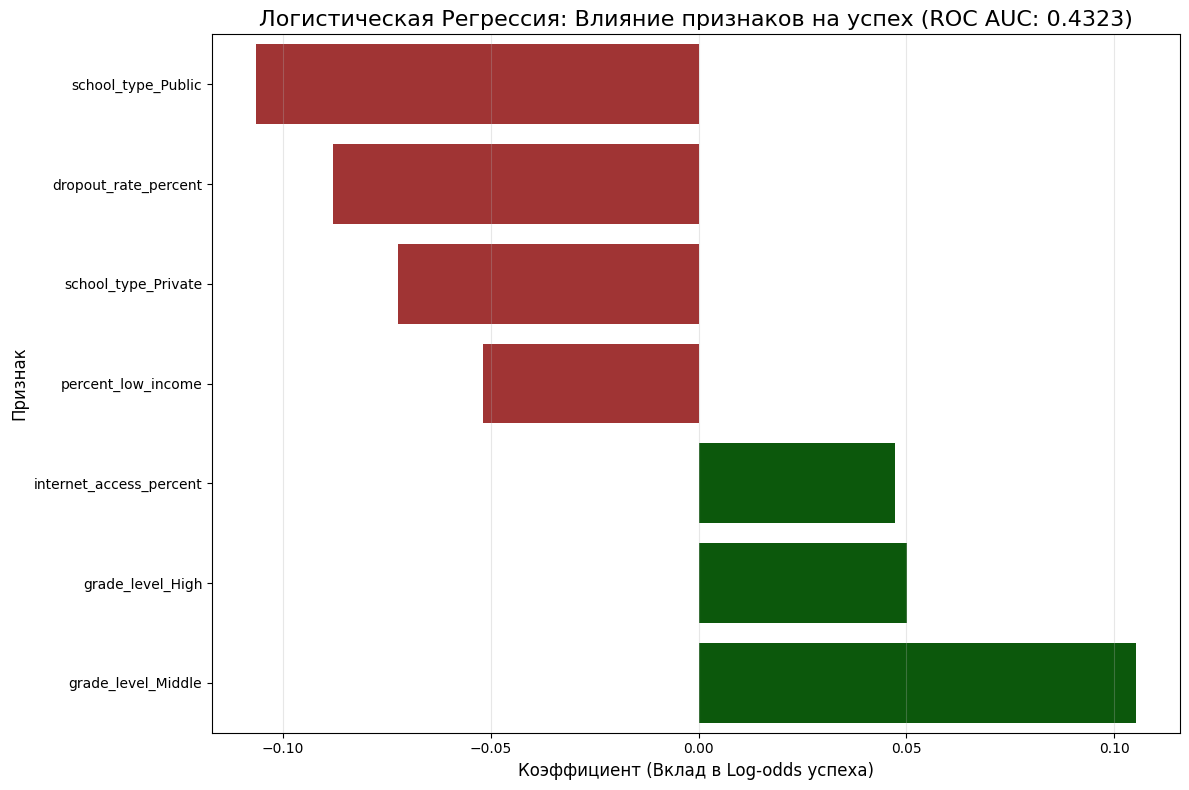

In [33]:
coefficients = pd.Series(model_log.coef_[0], index=X_processed.columns).sort_values(ascending=False)

significant_coefficients = coefficients[abs(coefficients) > 0.025].copy()
significant_coefficients = significant_coefficients.sort_values(ascending=True)

plt.figure(figsize=(12, 8))
colors = ['darkgreen' if x > 0 else 'firebrick' for x in significant_coefficients.values]
sns.barplot(x=significant_coefficients.values, y=significant_coefficients.index, palette=colors)

roc_auc_score_value = roc_auc_score(y_test, y_proba)
plt.title(f'Логистическая Регрессия: Влияние признаков на успех (ROC AUC: {roc_auc_score_value:.4f})', fontsize=16)
plt.xlabel('Коэффициент (Вклад в Log-odds успеха)', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Коэффициенты Логистической регрессии показывают, как изменение каждого признака влияет на логарифм шансов (log-odds) отнесения школы к классу "Высокий балл" (Score High).

Самыми сильными положительными предикторами (повышающими шансы получить высокий балл) являются grade_level_Middle (Средние классы) и grade_level_High (Старшие классы). Также положительный вклад вносит internet_access_percent (процент доступа к интернету).

Наиболее отрицательными предикторами (понижающими шансы высокого балла) являются school_type_Public (Публичная школа), dropout_rate_percent (процент отсева) и school_type_Private (Частная школа). Признак percent_low_income (процент учеников с низким доходом) также негативно влияет на шансы.